In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import scipy as sp

# Data reading
import pandas as pd
import csv
import pickle

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# networkx
import networkx as nx
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community import k_clique_communities

from community import community_louvain

import scipy.sparse.linalg

import sklearn
from sklearn.cluster import KMeans 
import sklearn.preprocessing

import itertools
#sys.path
# graph-tools
#sys.path.append('/usr/local/Cellar/graph-tool/2.33/lib/python3.8/site-packages/')
from graph_tool.all import *

### Zachary's Karate Club

A Karate club of 34 members split into two parts after a dispute between a trainer and the president. It is a classic example in network theory and community detection and serevs as a first step for any community detection algorithm

See https://en.wikipedia.org/wiki/Zachary%27s_karate_club for details

@ This notebook has shamelessly copied from notebooks provided by Eduardo Altmann (4th year course!)

# I. Read in networks 

In [2]:
G_HST1=nx.karate_club_graph();

print('number of nodes of G:',nx.number_of_nodes(G_HST1))
print('numbber of edges of G:',nx.number_of_edges(G_HST1))

number of nodes of G: 34
numbber of edges of G: 78


In [3]:
# Choose the network to be analyzed below
G0=G_HST1

print('number of nodes of the full G:',len(G0.nodes))
print('Is the full G connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

# restrict to largest connected component
largest_cc = max(nx.connected_components(G0),key=len)
G0=G0.subgraph(largest_cc)
print('number of nodes of restricted full G:',len(G0.nodes))

#Gc = max(nx.connected_component_subgraphs(G0), key=len)
print('number of nodes of largest connected component of G:',len(G0.nodes))

print('number of nodes of G0:',nx.number_of_nodes(G0))
print('number of edges of G0:',nx.number_of_edges(G0))

# randomize according to degree-preserving Maslov-Sneppen algorithm
G0_randomized = nx.random_reference(G0,connectivity=True) 
print('Is the randomized G connected?',nx.connected.is_connected(G0_randomized))
# delete nodes without any links
# G0.nodes

number of nodes of the full G: 34
Is the full G connected? True
How many connected subgraphs are there? 1
number of nodes of restricted full G: 34
number of nodes of largest connected component of G: 34
number of nodes of G0: 34
number of edges of G0: 78
Is the randomized G connected? True


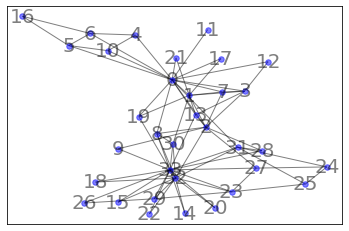

In [4]:
nx.draw_networkx(G0, node_size=30, alpha=0.5, node_color="blue", font_size='20',with_labels=True)
plt.show()

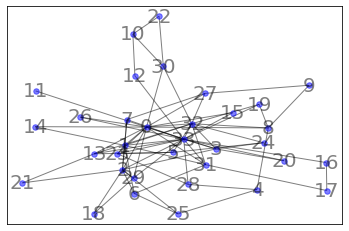

In [5]:
nx.draw_networkx(G0_randomized, node_size=30, alpha=0.5, node_color="blue", font_size='20',with_labels=True)
plt.show()

# II. Centrality measures 

## Clustering

$\large{C_{net}}$

In [6]:
G = G0
G_randomized = nx.random_reference(G,connectivity=True) 
print('C_net of G:',nx.transitivity(G))
print('C_net of randomized G:',nx.transitivity(G_randomized));

C_net of G: 0.2556818181818182
C_net of randomized G: 0.19886363636363635


In [ ]:
cluster=nx.clustering(G,nodes=G.nodes)

In [7]:
#print('Clustering:',nx.clustering(G))
totalC=0
cluster=nx.clustering(G,nodes=G.nodes)
cluster_keys=list(cluster)
cluster_values=list(cluster.values())
for n in range(len(G.nodes)):
    totalC = totalC+cluster_values[n]
print("Average clustering of G = "+str(totalC/nx.number_of_nodes(G)) )

totalC=0
cluster=nx.clustering(G_randomized,nodes=G_randomized.nodes)
cluster_keys=list(cluster)
cluster_values=list(cluster.values())
for n in range(len(G_randomized.nodes)):
    totalC = totalC+cluster_values[n]
print("Average clustering of randomized G= "+str(totalC/nx.number_of_nodes(G_randomized)) )


Average clustering of G = 0.5706384782076823
Average clustering of randomized G= 0.26818837160532666


## Degree

In [8]:
dgList=[]
#print('asd',G.degree)
for i in G.degree():
    dgList.append([i[1],i[0]])
dgList.sort()
dgList.reverse()
for j in dgList[:10]:
    print("Node "+str(j[1])+" has degree "+str(j[0])) 

Node 33 has degree 17
Node 0 has degree 16
Node 32 has degree 12
Node 2 has degree 10
Node 1 has degree 9
Node 31 has degree 6
Node 3 has degree 6
Node 23 has degree 5
Node 13 has degree 5
Node 8 has degree 5


## Shortest Path

In [9]:
dij=dict(nx.shortest_path_length(G))
diList=[]
for k in dij:
    di=np.average(list(dict(dij[k]).values()))
    diList.append([di,k])
#    print("Node i=",k," has <d_i>=",di)
diList.sort()
print("Top 10 nodes with shortest <d_i>:\n")
for i in diList[:10]:
    print("\t Node i=",i[1]," has <d_i>=",i[0])

Top 10 nodes with shortest <d_i>:

	 Node i= 0  has <d_i>= 1.7058823529411764
	 Node i= 2  has <d_i>= 1.7352941176470589
	 Node i= 33  has <d_i>= 1.7647058823529411
	 Node i= 31  has <d_i>= 1.7941176470588236
	 Node i= 8  has <d_i>= 1.8823529411764706
	 Node i= 13  has <d_i>= 1.8823529411764706
	 Node i= 32  has <d_i>= 1.8823529411764706
	 Node i= 19  has <d_i>= 1.9411764705882353
	 Node i= 1  has <d_i>= 2.0
	 Node i= 3  has <d_i>= 2.088235294117647


## Betweeness centrality

In [10]:
nx.betweenness_centrality(G0)

{0: 0.43763528138528146,
 1: 0.053936688311688304,
 2: 0.14365680615680618,
 3: 0.011909271284271283,
 4: 0.0006313131313131313,
 5: 0.02998737373737374,
 6: 0.029987373737373736,
 7: 0.0,
 8: 0.05592682780182781,
 9: 0.0008477633477633478,
 10: 0.0006313131313131313,
 11: 0.0,
 12: 0.0,
 13: 0.04586339586339586,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.03247504810004811,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.017613636363636363,
 24: 0.0022095959595959595,
 25: 0.0038404882154882154,
 26: 0.0,
 27: 0.02233345358345358,
 28: 0.0017947330447330447,
 29: 0.0029220779220779218,
 30: 0.014411976911976909,
 31: 0.13827561327561325,
 32: 0.145247113997114,
 33: 0.30407497594997596}

In [ ]:
nx.betweenness_centrality(G0_randomized);

## Eigenvector

In [ ]:
nx.eigenvector_centrality(G0);

In [ ]:
nx.eigenvector_centrality(G0_randomized);

In [11]:
measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
listMeasures = [dict(nx.degree(G)),nx.eigenvector_centrality_numpy(G),nx.katz_centrality_numpy(G),nx.pagerank(G),nx.betweenness_centrality(G)]

for idx,dictMeasure in enumerate(listMeasures):
    top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
    top10.sort(reverse=True)
    print("\n Centrality Measure:",measuresNames[idx])
    for idx,pair in enumerate(top10[:10]):
        print(str(idx+1),": \t is node ",pair[1]," with value:\t",pair[0])


 Centrality Measure: Degree
1 : 	 is node  33  with value:	 17
2 : 	 is node  0  with value:	 16
3 : 	 is node  32  with value:	 12
4 : 	 is node  2  with value:	 10
5 : 	 is node  1  with value:	 9
6 : 	 is node  31  with value:	 6
7 : 	 is node  3  with value:	 6
8 : 	 is node  23  with value:	 5
9 : 	 is node  13  with value:	 5
10 : 	 is node  8  with value:	 5

 Centrality Measure: Eigenvector
1 : 	 is node  33  with value:	 0.37336347029148315
2 : 	 is node  0  with value:	 0.35549144452456677
3 : 	 is node  2  with value:	 0.31719250448643155
4 : 	 is node  32  with value:	 0.30864421979104734
5 : 	 is node  1  with value:	 0.2659599195524917
6 : 	 is node  8  with value:	 0.22740390712540012
7 : 	 is node  13  with value:	 0.2264727201424813
8 : 	 is node  3  with value:	 0.21117972037789032
9 : 	 is node  31  with value:	 0.1910338414065437
10 : 	 is node  30  with value:	 0.1747583023143528

 Centrality Measure: Katz
1 : 	 is node  33  with value:	 0.3314064273997825
2 : 	 i

In [12]:
measuresNames=["Degree","Eigenvector","Katz","Page Rank","Betweeness"]
listMeasures = [dict(nx.degree(G_randomized)),nx.eigenvector_centrality_numpy(G_randomized),nx.katz_centrality_numpy(G_randomized),nx.pagerank(G_randomized),nx.betweenness_centrality(G_randomized)]

for idx,dictMeasure in enumerate(listMeasures):
    top10 = [[dictMeasure[k],k] for k in dictMeasure.keys()] # Choose the 10 largest values
    top10.sort(reverse=True)
    print("\n Centrality Measure:",measuresNames[idx])
    for idx,pair in enumerate(top10[:10]):
        print(str(idx+1),": \t is node ",pair[1]," with value:\t",pair[0])


 Centrality Measure: Degree
1 : 	 is node  33  with value:	 17
2 : 	 is node  0  with value:	 16
3 : 	 is node  32  with value:	 12
4 : 	 is node  2  with value:	 10
5 : 	 is node  1  with value:	 9
6 : 	 is node  31  with value:	 6
7 : 	 is node  3  with value:	 6
8 : 	 is node  23  with value:	 5
9 : 	 is node  13  with value:	 5
10 : 	 is node  8  with value:	 5

 Centrality Measure: Eigenvector
1 : 	 is node  33  with value:	 0.3975099452330993
2 : 	 is node  0  with value:	 0.3826857901436133
3 : 	 is node  32  with value:	 0.3583503101999119
4 : 	 is node  1  with value:	 0.2966218131170027
5 : 	 is node  2  with value:	 0.27484493249367786
6 : 	 is node  31  with value:	 0.22608165145667605
7 : 	 is node  30  with value:	 0.20447300287004944
8 : 	 is node  3  with value:	 0.19855225111867664
9 : 	 is node  13  with value:	 0.1693777649698125
10 : 	 is node  7  with value:	 0.1533455442588137

 Centrality Measure: Katz
1 : 	 is node  33  with value:	 0.3507669090022158
2 : 	 is 

# III.  Community detection

In [13]:
def partToList(part):
    '''Print partition as a list'''
    N=0
    for b in range(len(part)):
        N=N+len(part[b])
    listP=np.zeros(N)
    for b in range(len(part)):
        for n in part[b]:
            listP[n]=b
    return(listP)

def partToList_for_strings(part,G):
    '''Print partition as a list'''
    N=0
    for b in range(len(part)):
        N=N+len(part[b])
    listP=np.zeros(N)
    for b in range(len(part)):
        for n in part[b]:
            #print('n',n)
            #print('type part=',type(part))
            #ind_n = part[b].index(n) 
            ind_n = list(G.nodes).index(n)
            #print('ind_n',ind_n)
            listP[ind_n]=b
    return(listP)

## III a. Spectral methods

## Modularity

In [14]:
G0_mod = nx.modularity_matrix(G0, nodelist=None, weight=None)

# modularity (is numpy.matrix)
EVal, EVec = np.linalg.eig(G0_mod)
idx = np.argsort(EVal)
idx = idx[::-1]
EVal_mod = EVal.real[idx]
EVec_mod = EVec[:,idx]
print('lambda_mod=',EVal_mod[1:6])

lambda_mod= [3.04278102 2.32020502 1.48883282 1.45942182 1.08328648]


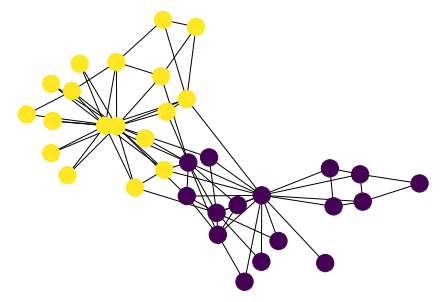

In [15]:
#print('EVec_mod=',EVec_mod[:,0])
#partClub = 0.5*(np.sign(EVec_mod.real[:,0])+1)
partClub = np.sign(EVec_mod.real[:,0])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)
#print('ind_neg=',ind_neg,ind_pos)
#print('partClub=',partClub)
#print('ind_neg=',ind_neg,ind_pos,len(partClub),partClub[1],partClub)

layout = nx.spring_layout(G0)
nx.draw(G0,pos=layout,node_color=partToList(partClub))

## Random walk (almost invariant sets)

lambda_Markov= [ 1.          0.86772767  0.71295101  0.61268677 -0.61190959 -0.71461135]


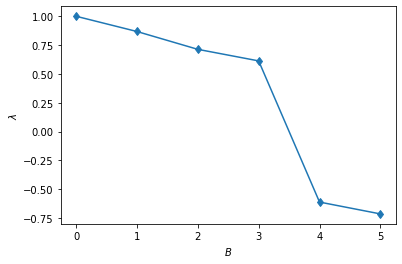

In [16]:
G0_Ad = nx.adjacency_matrix(G0, nodelist=None, weight=None)
# adjacency matrix (is scipy.sparse.csr.csr_matrix)

G0_D = G0_Ad.sum(axis=1)
G0_D = sp.sparse.spdiags(G0_D.flatten(), [0], len(G0.nodes), len(G0.nodes), format='csr')
G0_Markov = sp.sparse.linalg.inv(G0_D).dot(G0_Ad) # right eigenvector (expectation values)
G0_Markov = G0_Ad.dot(sp.sparse.linalg.inv(G0_D)) # left eigenvector (density)

#qwe=sp.sparse.csr_matrix.todense(G0_D)
#print('degree:',qwe[0:4][0:4])
#G0.degree

# Markov matrix (is scipy.sparse.csr.csr_matrix)
G0_Markov = G0_Markov.astype(float);
EVal, EVec = sp.sparse.linalg.eigs(G0_Markov,k=6)
idx = np.argsort(EVal)
idx = idx[::-1]
EVal_Markov = EVal.real[idx]
EVec_Markov = EVec[:,idx]
print('lambda_Markov=',EVal_Markov.real)

#plt.plot(e,"-o")
plt.plot(EVal_Markov,"-d")
plt.xlabel("$B$")
plt.ylabel("$\lambda$")
plt.show()

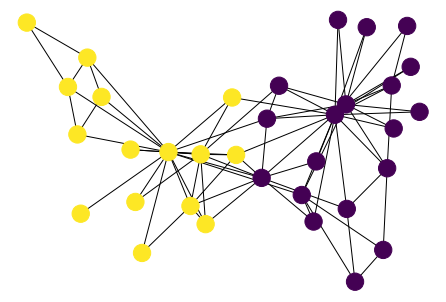

In [17]:
partClub = np.sign(EVec_Markov.real[:,1])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

layout = nx.spring_layout(G0)
nx.draw(G0,pos=layout,node_color=partToList(partClub))

## Graph Laplacian

lambda_Lap= [6.79901018e-16 4.68525227e-01 9.09247664e-01 1.12501072e+00
 1.25940411e+00 1.59928308e+00 1.76189862e+00 1.82605521e+00
 1.95505045e+00 2.00000000e+00 2.00000000e+00 2.48709173e+00
 2.74915718e+00 3.01396297e+00 3.24206748e+00]


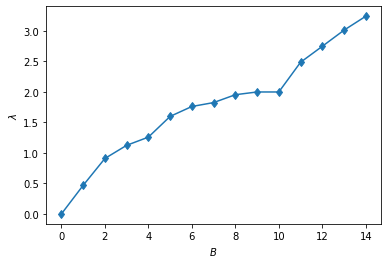

In [18]:
G0_Lap = nx.laplacian_matrix(G0, nodelist=None, weight=None)

# graph Laplacian matrix (is scipy.sparse.csr.csr_matrix)
G0_Lap = G0_Lap.astype(float)
#G0_Lap = G0_Lap.asfptype()

EVal, EVec = sp.sparse.linalg.eigs(G0_Lap,k=15,which='SR')
idx = np.argsort(EVal)
#idx = idx[::-1]
EVal_Lap = EVal.real[idx]
EVec_Lap = EVec[:,idx]
print('lambda_Lap=',EVal_Lap)

G0_lap_v2 = nx.fiedler_vector(G0, weight=None, normalized=False, tol=1e-08, seed=None)
#print('Fiedler=',G0_lap_v2)
#print('v2=',EVec_Lap.real[:,1])

## compare different eigenvalue routines (don't trust the higher ones)
# e = np.linalg.eigvals(G0_Lap.A)
# L.A is shorthand for L.toarray()

#plt.plot(e,"-o")
plt.plot(EVal_Lap,"-d")
plt.xlabel("$B$")
plt.ylabel("$\lambda$")
plt.show()

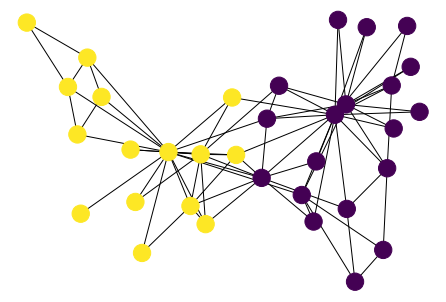

In [19]:
partClub = np.sign(EVec_Lap.real[:,1])
#partClub = np.sign(G0_lap_v2)

ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

nx.draw(G0,pos=layout,node_color=partToList(partClub))

## Normalized Graph Laplacian

In [20]:
G0_normLap = nx.normalized_laplacian_matrix(G0, nodelist=None, weight=None)

# normalized graph Laplacian matrix (is scipy.sparse.csr.csr_matrix)
G0_normLap = G0_normLap.astype(float)
EVal, EVec = sp.sparse.linalg.eigs(G0_normLap,k=6,which='SR')
idx = np.argsort(EVal)
#idx = idx[::-1]
EVal_normLap = EVal.real[idx]
EVec_normLap = EVec[:,idx]
print('lambda_normLap=',EVal_normLap)

G0_normlap_v2 = nx.fiedler_vector(G0, weight=None, normalized=True, tol=1e-08, seed=None)


lambda_normLap= [5.55111512e-17 1.32272329e-01 2.87048985e-01 3.87313233e-01
 6.12230540e-01 6.48992947e-01]


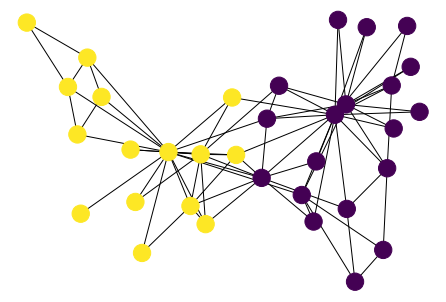

In [21]:
partClub = np.sign(EVec_normLap.real[:,1])
#partClub = np.sign(G0_normlap_v2)

ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

nx.draw(G0,pos=layout,node_color=partToList(partClub))

## Bethe Hessian


In [22]:
G0_BetheLap = nx.bethe_hessian_matrix(G0, r=None, nodelist=None)

# Bethe Laplacian matrix (is scipy.sparse.csr.csr_matrix)
G0_BetheLap = G0_BetheLap.astype(float)
EVal, EVec = sp.sparse.linalg.eigs(G0_BetheLap,k=6,which='SR')
idx = np.argsort(EVal)
#idx = idx[::-1]
EVal_BetheLap = EVal.real[idx]
EVec_BetheLap = EVec[:,idx]
print('lambda_Bethe=',EVal_BetheLap)


lambda_Bethe= [ 7.98495674 19.20197756 29.667738   33.20721293 39.14638743 39.55402896]


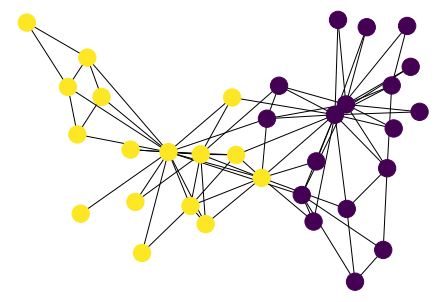

In [23]:
partClub = np.sign(EVec_BetheLap.real[:,1])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

nx.draw(G0,pos=layout,node_color=partToList(partClub))

## Adjacency matrix

In [24]:
G0_Ad = nx.adjacency_matrix(G0, nodelist=None, weight=None)

# adjacency matrix (is scipy.sparse.csr.csr_matrix)
#G0_ad = sp.sparse.csr_matrix.todense(G0_Ad)
#EVal, EVec = sp.linalg.eig(G0_ad)
G0_Ad = G0_Ad.astype(float)
EVal, EVec = sp.sparse.linalg.eigs(G0_Ad,k=6,which='LR')
idx = np.argsort(EVal)
idx = idx[::-1]
EVal_Ad = EVal.real[idx]
EVec_Ad = EVec[:,idx]
print('lambda_Ad=',EVal_Ad)


lambda_Ad= [6.72569773 4.97707423 2.9165067  2.30908767 1.48615954 1.45305566]


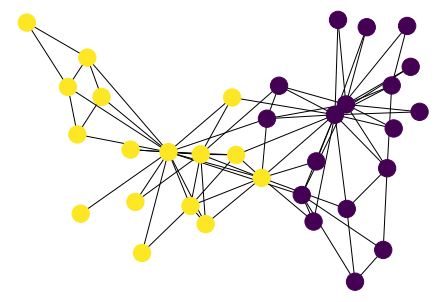

In [25]:
partClub = np.sign(EVec_Ad.real[:,1])
ind_neg = [i for i in range(len(partClub)) if partClub[i]<0] 
ind_pos = [i for i in range(len(partClub)) if partClub[i]>0] 
partClub = (ind_neg,ind_pos)

nx.draw(G0,pos=layout,node_color=partToList(partClub))

## III b. Modularity community detection algorithms

### Girvan-Newman algorithm

In [26]:
# Girvan-Newman
partGirvanNewman = community.girvan_newman(G0)
numb_commun_div = 3;

for communities in itertools.islice(partGirvanNewman, numb_commun_div):
    #print(tuple(sorted(c) for c in communities))
    partGirvanNewman=tuple(sorted(c) for c in communities)

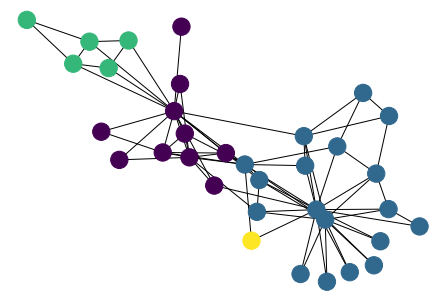

In [27]:
#print('partClub=',partGirvanNewman)
#print('# of partitions=',len(partGirvanNewman))
#print('NodeType:',NodeType)
#print('partTolist(oartGirvanNewman)=',partToList(partGirvanNewman,G0))

layout = nx.spring_layout(G0)
nx.draw(G0,pos=layout,node_color=partToList_for_strings(partGirvanNewman,G0))  

### Greedy modularity maximizing algorithm

# of partitions = 3 
 modularity = 0.3806706114398414


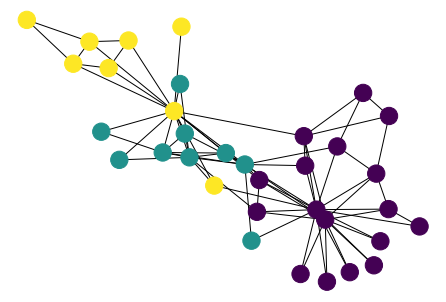

In [28]:
## Determine the number of communities such that modularity is maximized in a greedy algorithm
partGreedy = community.greedy_modularity_communities(G0)
print('# of partitions =',len(partGreedy),'\n modularity =',community.modularity(G0,partGreedy))
nx.draw(G0,pos=layout,node_color=partToList_for_strings(partGreedy,G0))

### Louvain group modularity algorithm

!pip3 install python-louvain

https://iopscience.iop.org/article/10.1088/1742-5468/2008/10/P10008

https://en.wikipedia.org/wiki/Louvain_modularity


# of partitions for Louvain modularity = 4


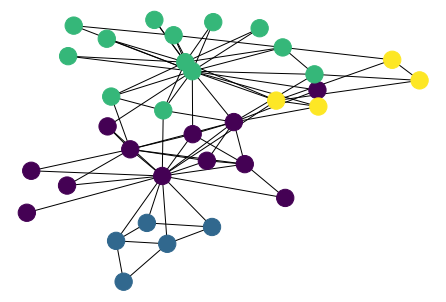

In [29]:
partLouvain = community_louvain.best_partition(G0)
layout_PPI = nx.spring_layout(G0,k=1/np.sqrt(len(G0)))
nx.draw(G0,pos=layout_PPI,node_color=list(partLouvain.values()))

number_of_communities = max(list(partLouvain.values()))+1
print('# of partitions for Louvain modularity =',number_of_communities)

#cmap = cm.get_cmap('viridis', max(partLouvain.values()) + 1)
#nx.draw_networkx_nodes(G0, pos=layout, partition.keys(), node_size=40,
#cmap=cmap, node_color=list(partLouvain.values()))
#nx.draw_networkx_edges(G0, pos=layout, alpha=0.5)
#plt.show()

## III c. k-clique algorithm 
-- Jonsson et al BMC Bioinformatics 2006, 7:2 

In [30]:
# size of smallest clique:
kc = 3 
k_clique_set = k_clique_communities(G0, kc)

k_clique_list = list(k_clique_set)

number of nodes of largest connected component of G: 34
Number of k-cliques: 3
Size of a k-clique: 25


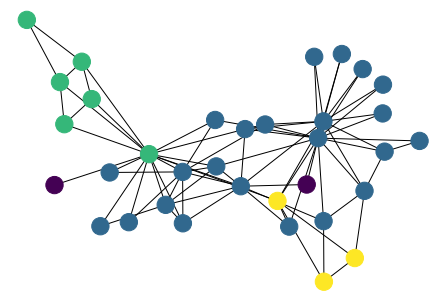

In [31]:
def longest(l):
    if not isinstance(l, list):
        return 0
    return max(
            [len(l)] 
            + [len(subl) for subl in l if isinstance(subl, list)] 
            + [longest(subl) for subl in l]
            )

print('number of nodes of largest connected component of G:',len(G0.nodes))
print('Number of k-cliques:',longest(k_clique_list))
print('Size of a k-clique:',len(k_clique_list[0]))

layout_PPI = nx.spring_layout(G0,k=1/np.sqrt(len(G0)))
#nx.draw(G0,pos=layout_PPI,node_color=list(partLouvain.values()))
#for i in range(len(k_clique_list)):
#    clique = k_clique_list[i]
#    node_list = [node for node in clique]
#    print('asd',[i]*len(node_list))
#    nx.draw(G0,pos=layout_PPI,nodelist=node_list,node_color=[i]*len(node_list))

color = [-1]*G0.number_of_nodes()
for i in range(len(k_clique_list)):
   clique = list(k_clique_list[i])
   for node in clique:
       color[node] = i
nx.draw(G0,pos=layout_PPI,node_color=color)
plt.show()